In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from qkit.analysis.semiconductor.loaders.Loaderh5 import Loaderh5
from qkit.analysis.semiconductor.analyzers.AnalyzerTimetraceSpectralNoiseDensity import AnalyzerTimetraceSpectralNoiseDensity
from qkit.analysis.semiconductor.plotters.PlotterTimetraceSpectralNoiseDensity import PlotterTimetraceSpectralNoiseDensity
from qkit.analysis.semiconductor.analyzers.AnalyzerPeakTracker_Daniel import AnalyzerPeakTracker
from qkit.analysis.semiconductor.plotters.PlotterPlungerTimetrace3D import PlotterPlungerTimetrace3D
from qkit.analysis.semiconductor.plotters.PlotterPlungerTraceFit import PlotterPlungerTraceFit
from qkit.analysis.semiconductor.plotters.PlotterPlungerTraceTimestampsDifference import PlotterPlungerTraceTimestampsDifference
from qkit.analysis.semiconductor.plotters.PlotterTimetraceJumpsHistogram import PlotterTimetraceJumpsHistogram
from qkit.analysis.semiconductor.main.SlicerPlungerTimetrace import SlicerPlungerTimetrace
from qkit.analysis.semiconductor.loaders.Loader_spectrum_np import Loader_spectrum_np
from qkit.analysis.semiconductor.savers.Saver_spectrum_np import Saver_spectrum_np
from qkit.analysis.semiconductor.savers.Saver_json import Saver_json
from qkit.analysis.semiconductor.main.pre_formatted_figures import SemiFigure
from qkit.analysis.semiconductor.loaders.LoaderJSON import LoaderJSON


import os
import matplotlib.pyplot as plt
import pathlib
from qkit.analysis.semiconductor.analyzers.AnalyzerPeakTracker import Analyzer as Peak_hunt
from qkit.analysis.semiconductor.analyzers.AnalyzerTimetraceJumps  import Analyzer as jump_count
from qkit.analysis.semiconductor.main.fit_functions import gauss_function

QKIT configuration initialized -> available as qkit.cfg[...]


# Choose the Data

In [96]:
date_time_string = "20220518/120037"#"20220518/211236"
date = date_time_string.split("/")[0]
time = date_time_string.split("/")[1]
filepath = f"sftp://tp1435@os-login.lsdf.kit.edu/kit/phi/projects/nanospin/SEMICONDUCTOR_SYSTEMS/data/{date}/{time}_2D_Peak_tracking/{time}_2D_Peak_tracking.h5"
savepath = os.path.join("/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/",
                        str(pathlib.Path(filepath).parents[1]).split("/")[-1],
                        str(pathlib.Path(filepath).parents[0]).split("/")[-1])
overview_path = "/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/"

configpath = "/home/ws/lr1740/Dokumente/Doktorarbeit/Sonstiges/sftp_config.txt"

saver = Saver_json(savepath)
saver_overview = Saver_json(overview_path)
bcv = input("Specify current bias cooling voltage in V: ")

saver_overview.fname = "P35B4"
saver_overview.append_to_file = True

print("Savepath: " + savepath)

settings = {"file_info" : {
                "filepath" : filepath,
                "savepath" : savepath,
                "analysis" : "plunger_sweep_timetrace"},
            "meas_params" : {
                "measurement_amp" : 100e-6,
                "voltage_divider" : 3,
                "IVgain" : 1e8,
                "in_line_R": 40e3},
            "authentication" : {
                "configpath" : configpath}
            }

Specify current bias cooling voltage in V: 80
Savepath: /V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/20220518/120037_2D_Peak_tracking


In [97]:
loader = Loaderh5()
data, _ = loader.load(settings)
print(data.keys())
print("\n")
print(data["static_voltages"])
vr = input("Specify reference votlage in V: ")

Done loading file, formatting now...
dict_keys(['demod0&4.r0', 'demod0&4.r4', 'demod0&4.timestamp0', 'demod0&4.timestamp4', 'demod0&4.x0', 'demod0&4.x4', 'demod0&4.y0', 'demod0&4.y4', 'demod4.r4', 'demod4.timestamp4', 'demod4.x4', 'demod4.y4', 'gates_6_16', 'measurement', 'number', 'settings', 'static_voltages'])


['{\n    "gate10_out": 0.6549072265625,\n    "gate11_out": 0.6549072265625,\n    "gate12_out": 0.6549072265625,\n    "gate13_out": 0.6549072265625,\n    "gate14_out": 2.69622802734375,\n    "gate15_out": 2.69622802734375,\n    "gate16_out": 0.6549072265625,\n    "gate17_out": 2.69622802734375,\n    "gate18_out": 0.6549072265625,\n    "gate19_out": 0.6549072265625,\n    "gate20_out": 0.6549072265625,\n    "gate21_out": 0.6549072265625,\n    "gate22_out": 0.6549072265625,\n    "gate23_out": 0.6549072265625,\n    "gate4_out": 3.31024169921875,\n    "gate5_out": 0.56243896484375,\n    "gate6_out": 0.6390380859375,\n    "gate7_out": 0.88470458984375,\n    "gate9_out": 0.654907226

In [100]:
side = input("Specify side of SET (l/r): ")
tgv = input("Specify current top gate voltage in V: ")
while side != "l" and side != "r":
    side = input("Specify side of SET (l/r): ")

demod_prefix = "demod0&4"
if side == "l":
    demod_idx = 0
else:
    demod_idx = 4
    
node_timestamp = f"{demod_prefix}.timestamp{demod_idx}"
node_x = f"{demod_prefix}.x{demod_idx}"
node_y = f"{demod_prefix}.y{demod_idx}"
node_r = f"{demod_prefix}.r{demod_idx}"

gates = "gates_6_16"

Specify side of SET (l/r): l
Specify current top gate voltage in V: 80


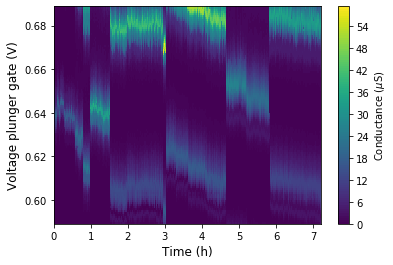

In [101]:
plotter = PlotterPlungerTimetrace3D()
plotter.max_cond = None
plotter.plot(settings, data, [node_timestamp, gates , node_r])

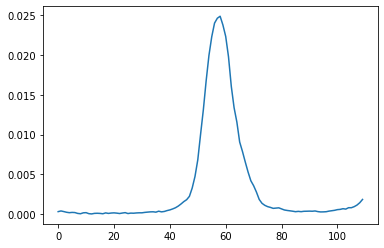

In [81]:
plt.plot(data[node_r][0])

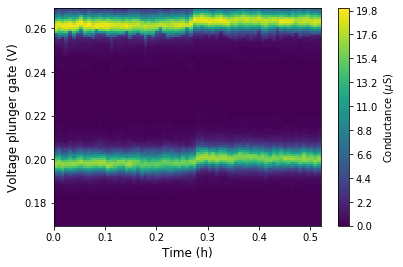

In [91]:
#%% Slice Data and Plot
slicer = SlicerPlungerTimetrace()
slicer.beginning, slicer.ending = 2.4, 4 # in hours
data_sliced = slicer.slice(data, [node_timestamp, gates , node_r])

plotter = PlotterPlungerTimetrace3D()
plotter.max_cond = None
plotter.savename = "plunger_timetrace_sliced"
plotter.plot(settings, data_sliced, [node_timestamp, gates , node_r])

In [92]:
yeno = input("Do you wish to continue to work with the sliced data? [y/n]")
if yeno == "y":
    data_raw = data.copy()
    data = data_sliced
    print("You are now working with the sliced data")

Do you wish to continue to work with the sliced data? [y/n]y
You are now working with the sliced data


# Let the peak hunt begin!

## The bloodmoon has risen over the city of Yharnam...

Number of tracked peaks: 2
Length of chosen peak track: 72
Length of samples: 72


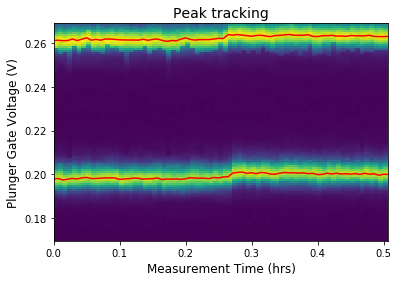

In [93]:
peak_hunter = Peak_hunt(data[node_r], data[node_timestamp], data[gates])
peak_hunter.pf.min_peak_height = 0.01
peak_hunter.pf.min_peak_width = 5
peak_hunter.pf.min_peak_distance = None #Can also be None, for no min distance
peak_hunter.pf.fit_interval_peak_relheight = 1
peak_hunter.rel_jump_height = 1
tracked_peaks = peak_hunter.analyze()

print(f"Number of tracked peaks: {len(tracked_peaks['tracked_peak_positions'])}")
index_of_peak = 0
print(f"Length of chosen peak track: {len(tracked_peaks['tracked_peak_positions'][index_of_peak])}")
print(f"Length of samples: {len(data[node_r])}")

saver.add_info(f"{node_r}_tracked_peaks", tracked_peaks)

fig, ax1 = plt.subplots()
ax1.set_title("Peak tracking", fontsize = 14)
ax1.set_xlabel("Measurement Time (hrs)", fontsize = 12)
ax1.set_ylabel("Plunger Gate Voltage (V)", fontsize = 12)
ax1.set_axisbelow(True) # pushes grid to background
fig.set_facecolor("White")

ax1.pcolor(tracked_peaks["time_axis"]/3600, data[gates], np.transpose(data[node_r]))
for tracked_peak in tracked_peaks["tracked_peak_positions"]:
    length = min([len(tracked_peaks["time_axis"]), len(tracked_peak)])
    ax1.plot(tracked_peaks["time_axis"][:length]/3600, tracked_peak[:length], color = "r")
fig.savefig(os.path.join(savepath, "peak_tracking.png"), dpi = 400)

# Spectral noise density Calculation

In [234]:
def linear(x, a, b):
    return a * x + b

def bilinear2(x, a, b, c, switch_point):
    x = np.array(x)
    part1 = a * x[x <= switch_point] + b
    part2 = c * x[x > switch_point] + (a - c) * switch_point + b
    return np.concatenate((part1, part2))

2
0


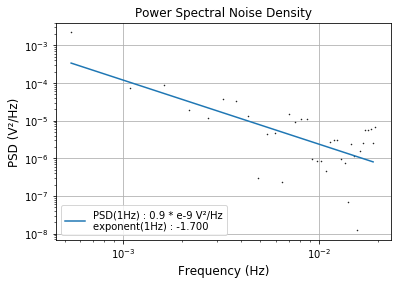

In [95]:
type_of_fit = "lin"
if type_of_fit == "lin":
    fit_func = linear
    guess = [-1, 1]
elif type_of_fit == "bilin":
    fit_func = bilinear2
    guess = [-2, 1, -1, -3]
    
sampling_f = tracked_peaks["time_axis"][1]**-1
peak_no = 0
noise_calculator = AnalyzerTimetraceSpectralNoiseDensity(tracked_peaks["tracked_peak_positions"][peak_no],\
                                                        sampling_f, fit_func = fit_func)

noise_calculator.welch_segment_length = 300
noise_calculator.guess = guess
saver.add_info(f"{node_r}_peak{peak_no}_welch_segment_length", noise_calculator.welch_segment_length)
saver.add_info(f"{node_r}_peak{peak_no}_fit_interval", noise_calculator.fit_interval)

spectral_result = noise_calculator.analyze()
saver.add_info(f"{node_r}_peak{peak_no}_spectrum", spectral_result)
saver_overview.add_info(f"{node_r}_peak{peak_no}_spectrum", spectral_result)

fit = noise_calculator.fit()
saver.add_info(f"{node_r}_peak{peak_no}_SNDfit_parameters", fit)
saver_overview.add_info(f"{node_r}_peak{peak_no}_SNDfit_parameters", fit)

f, s = spectral_result["freq"], spectral_result["spectrogram"]
saving_path = os.path.join(settings["file_info"]["savepath"], node_r)

plotter_SND = PlotterTimetraceSpectralNoiseDensity(saving_path, [f,s], fit)
plotter_SND.plot()

In [157]:
saver_overview.additional_info.keys()

dict_keys(['demod0&4.r0_peak0_spectrum', 'demod0&4.r0_peak0_SNDfit_parameters', 'demod0&4.r0_peak0_big_jumps', 'demod0&4.r0_peak0_jumpfit_parameters', 'demod0&4.r4_peak0_spectrum', 'demod0&4.r4_peak0_SNDfit_parameters', 'demod0&4.r4_peak0_big_jumps', 'demod0&4.r4_peak0_jumpfit_parameters', 'demod0&4.r4_peak1_spectrum', 'demod0&4.r4_peak1_SNDfit_parameters', 'demod0&4.r4_peak1_big_jumps', 'demod0&4.r4_peak1_jumpfit_parameters', 'demod0&4.r4_peak2_spectrum', 'demod0&4.r4_peak2_SNDfit_parameters', 'demod0&4.r4_peak2_big_jumps', 'demod0&4.r4_peak2_jumpfit_parameters'])

# Jump analysis

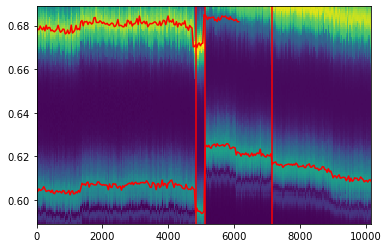

In [47]:
#peak_no = 0
jump_analysis = jump_count(tracked_peaks["tracked_peak_positions"][peak_no], tracked_peaks["time_axis"])
jump_analysis.big_jump_minimum_height = 5e-3
jump_analysis.bin_count = 100
jump_analysis.range = (-0.01, 0.01)
jump_analysis.guess = [20, 0, 0.0002]
jump_hist, big_jumps = jump_analysis.analyze()
popt = jump_analysis.fit()

saver.add_info(f"{node_r}_peak{peak_no}_jumphist", jump_hist)
saver.add_info(f"{node_r}_peak{peak_no}_big_jumps", big_jumps)
saver.add_info(f"{node_r}_peak{peak_no}_jumpfit_parameters", popt)

saver_overview.add_info(f"{node_r}_peak{peak_no}_big_jumps", big_jumps)
saver_overview.add_info(f"{node_r}_peak{peak_no}_jumpfit_parameters", fit)

plt.pcolor(tracked_peaks["time_axis"], data[gates], np.transpose(data[node_r]))
for tracked_peak in tracked_peaks["tracked_peak_positions"]:
    length = min([len(tracked_peaks["time_axis"]), len(tracked_peak)])
    plt.plot(tracked_peaks["time_axis"][:length], tracked_peak[:length], color = "r")
for jump_time in big_jumps["time_of_big_jumps"]:
    plt.axvline(jump_time, color = "r")

FHWM of the guassian distribution: 2.0782376156809677 mV


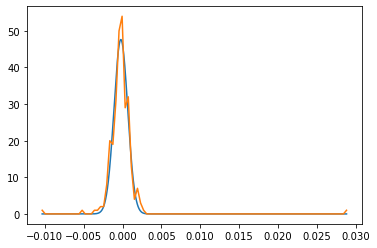

In [48]:
print(f"FHWM of the guassian distribution: {2.35482e3 * popt[-1]} mV")
x = np.linspace(min(jump_hist["jump_height"]), max(jump_hist["jump_height"]), 1000)
y = gauss_function(x, *popt)
plt.plot(x, y)
plt.plot(jump_hist["jump_height"], jump_hist["jumps_per_bin"])

# Save your analysis!

In [12]:
saver.save()

ovw = saver_overview.additional_info

saver_saver_overview = Saver_json(overview_path) #Save your saved data to be safe
analysis_key = f"{bcv}tg{tgv}vr{vr}side{side}"

saver_saver_overview.fname = saver_overview.fname
saver_saver_overview.append_to_file = True

saver_saver_overview.additional_info = {analysis_key : ovw}
saver_saver_overview.save()

In [13]:
print(analysis_key)

0.75tg1.414vr0.604sidel


# Look at the big picture!

In [5]:
from qkit.analysis.semiconductor.loaders.LoaderJSON import LoaderJSON
overview_path = "/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/"
sample = "P35B3"
fname = f"{sample}.json"

loader = LoaderJSON()
ovw_data = loader.load(os.path.join(overview_path, fname))

In [15]:
list(ovw_data.keys())[0].split("tg")[1].split("vr")[0].split("_")[0]

'1.106'

In [16]:
def extract_lowest_tgv(wanted_bcv, data_dict):
    tgvs = []
    matching_key = []
    for key in data_dict.keys():
        bcv = float(key.split("tg")[0])
        tgv = float(key.split("tg")[1].split("vr")[0].split("_")[0])
        if bcv == wanted_bcv:
            tgvs.append(tgv)
            matching_key.append(key)
            
    val = min(tgvs)
    idx = tgvs.index(val)
    return val, matching_key[idx]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_bcv(key):
    return float(key.split("tg")[0])

def get_tgv(key):
    return float(key.split("tg")[1].split("vr")[0])

def get_vref(key):
    return float(key.split("vr")[1].split("side")[0])

def get_side(key):
    return key.split("side")[1]

In [17]:
key1 = list(ovw_data.keys())[0]
print(key1)
print(get_bcv(key1))
print(get_tgv(key1))
print(get_vref(key1))
print(get_side(key1))

0tg1.106vr0.17sidel
0.0
1.106
0.17
l


0.38
-0.5tg0.38vr-0.446sidel
1.106
0tg1.106vr0.17sidel
1.239
0.75tg1.239vr0.604sidel
3.31
1.5tg3.31vr0.655sidel
[-0.5, 0.0, 0.75, 1.5]
[4.8261572383889475e-08, 8.323888694711713e-07, 1.0496780979454331e-07, 3.936699212260888e-05]


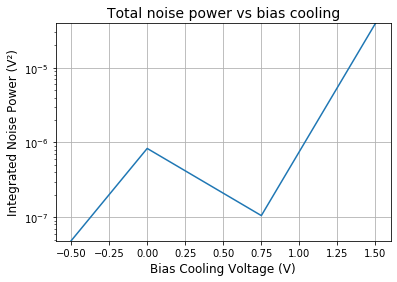

In [18]:
class bias_cool_plotter():
    def __init__(self, data_dict, y_maker, sample, y_scale = "log"):
        self.data_dict = data_dict
        self.y_maker = y_maker
        self._build_x_axis()
        self._build_y_axis()
        print(self.x_axis)
        print(self.y_axis)
        self.fig, self.ax1 = plt.subplots()
        self.ax1.set_title("Total noise power vs bias cooling")
        self.ax1.set_xlabel("Bias Cooling Voltage (V)")
        self.ax1.set_ylabel("Integrated Noise Power (V²)")
        self.ax1.set_yscale(y_scale)
        self.ax1.set_ylim(min(self.y_axis), max(self.y_axis))
        self.ax1.plot(self.x_axis, self.y_axis)
        
        self.set_dpi = 400
        #self.fig.set_bbox_inches = "tight"
        self.fig.save_as = ".png"
        self.fig.set_facecolor("White")
        self.ax1.set_axisbelow(True) # pushes grid to background
        self.ax1.title.set_size(fontsize=14)
        self.ax1.xaxis.label.set_size(fontsize=12)
        self.ax1.yaxis.label.set_size(fontsize=12)
        self.ax1.grid()
        self.fig.savefig(os.path.join(overview_path, f"{sample}_integrated_noise.png"), dpi = self.set_dpi)
    
    def _build_x_axis(self):
        x_vals = set()
        for key in self.data_dict.keys():
            bcv = get_bcv(key)
            x_vals.add(bcv)
        self.x_axis = sorted(list(x_vals))
    
    def _build_y_axis(self):
        self.y_axis = []
        for x_value in self.x_axis:
            y_value = self.y_maker(self.data_dict, x_value)
            self.y_axis.append(y_value)

    
def test_y_maker(data_dict, x_value):    
    return extract_lowest_tgv(x_value)

def format_float(float_no):
    if float_no.is_integer():
        key = f'{float_no:.0f}'
    else:
        key = f'{float_no}'
    return key

def find_key(data_dict, part_key):
    keys = data_dict.keys()
    #print(keys)
    #print(part_key)
    for key in keys:
        if part_key in key:
            return key
    return "not_found"

def one_mHz_value(data_dict, x_value):
    tgv, key = extract_lowest_tgv(x_value)
    #key = f"{format_float(x_value)}tg{tgv}"
    
    spectrum_key = find_key(data_dict[key], "spectrum")
    freqs = data_dict[key][spectrum_key]["freq"]
    spec = data_dict[key][spectrum_key]["spectrogram"]
    one_mHz_idx = find_nearest_idx(freqs, 1e-3)
    return spec[one_mHz_idx]

def func_power2(x, *params):
    x = np.array(x)
    if len(params) == 2:
        return params[1] * x ** params[0]
    else:
        part1 = params[1] * x[x <= params[3]] ** params[0]
        part2 = params[1]/(params[3] ** (params[2]-params[0])) * x[x > params[3]] ** params[2]
        return np.concatenate((part1, part2))

def one_mHz_value_fit(data_dict, x_value):
    tgv, key = extract_lowest_tgv(x_value)
    #key = f"{format_float(x_value)}tg{tgv}"
    
    fit_key = find_key(data_dict[key], "SNDfit")
    fit_pars = data_dict[key][fit_key]["popt"]
    
    return func_power2(1e-3, *fit_pars)

def integrated_noise_power(data_dict, x_value):
    tgv, key = extract_lowest_tgv(x_value)
    #key = f"{format_float(x_value)}tg{tgv}"
    
    spectrum_key = find_key(data_dict[key], "spectrum")
    freqs = data_dict[key][spectrum_key]["freq"]
    spec = data_dict[key][spectrum_key]["spectrogram"]
    integral = np.sum(np.diff(freqs) * spec[:-1])
    return integral

def integrated_noise_power_fit(data_dict, x_value):
    tgv, key = extract_lowest_tgv(x_value, data_dict)
    #key = find_key(data_dict, str(tgv))
    print(tgv)
    print(key)
    sub_key = "r0_peak0"
    fit_key = find_key(data_dict[key], sub_key + "_SNDfit")
    #print(fit_key)
    if fit_key != "not_found":
        fit_pars = data_dict[key][fit_key]["popt"]

        f_min = 1e-4
        f_max = 1e-2

        band = np.linspace(f_min, f_max, 100000)
        spec = func_power2(band, *fit_pars)

        integral = np.sum(np.diff(band) * spec[:-1])
        return integral

def fwhm(data_dict, x_value):
    tgv, key = extract_lowest_tgv(x_value)
    #key = f"{format_float(x_value)}tg{tgv}"
    
    jumpfit_key = find_key(data_dict[key], "jumpfit")
    popt = data_dict[key][jumpfit_key]["popt"]
    if len(popt) == 4:
        fwhm = data_dict[key][jumpfit_key]["popt"][-1]
    else:
        fwhm = 0
    return fwhm

def length_plot(data_dict, x_value):
    tgv, key = extract_lowest_tgv(x_value)
    #key = f"{format_float(x_value)}tg{tgv}"
    spectrum_key = find_key(data_dict[key], "r4_peak0_spectrum")
    freqs = data_dict[key][spectrum_key]["freq"]
    print(len(freqs))
    print(min(freqs))
    print(max(freqs))
    return len(freqs)


bias_cool_plotter(ovw_data, integrated_noise_power_fit, sample)

In [34]:
filtered_keys = []
sub_key = "r0_peak0"
for key in ovw_data.keys():
    if any(sub_key in key for key in ovw_data[key].keys()):
        filtered_keys.append(key)

print(filtered_keys)

filtered_dict = {key: value for key, value in ovw_data.items() if key in filtered_keys}

['0.75tg1.602vr1.104', '0tg0.703vr0.703', '0.75tg1.104vr1.104', '0tg0.838vr0.717', '0tg0.838_2ndvr0.717', '0.75tg1.380vr1.307', '0.75tg1.877vr1.307', '0.75tg1.877_2ndvr1.307', '0tg0.717vr0.717', '0.75tg1.341vr1.287', '1tg1.548vr1.390', '0.25tg1.429vr1.127', '0.25tg1.927vr1.127', '-0.5tg0.442vr0.127', '-0.5tg0.739vr0.127', '-1tg0.212vr-0.211']


In [37]:
extract_lowest_tgv(0.75, filtered_dict)

(1.104, '0.75tg1.104vr1.104')

In [92]:
filtered_dict.keys()

dict_keys(['0.75tg1.602vr1.104', '0tg0.887vr0.703', '0.75tg1.104vr1.104', '0.75tg2.051vr1.307', '0.75tg2.549vr1.307', '0tg0.567vr0.717', '0.75tg1.965vr1.287', '1tg1.626vr1.390', '0.25tg1.026vr1.127', '0.25tg1.524vr1.127'])

Text(0, 0.5, 'Delta V')

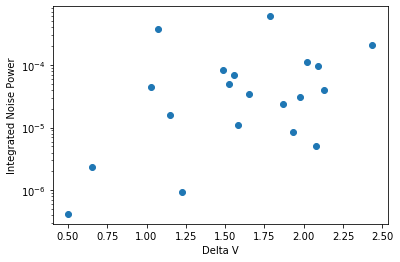

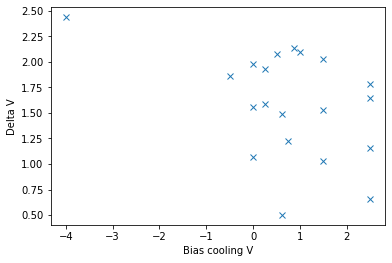

In [34]:
def get_Delta_tgv_rv(data_dict):
    x_data = []
    y_data = []
    bcv    = []
    for key in data_dict.keys():
        tgv = float(key.split("tg")[1].split("vr")[0].split("_")[0])
        rv = float(key.split("vr")[1])
        bcv.append(float(key.split("tg")[0]))
        x_data.append(tgv-rv)

        fit_key = find_key(data_dict[key], sub_key + "_SNDfit")
        #print(fit_key)
        if fit_key != "not_found":
            fit_pars = data_dict[key][fit_key]["popt"]

            f_min = 1e-4
            f_max = 1e-2

            band = np.linspace(f_min, f_max, 100000)
            spec = func_power2(band, *fit_pars)

            y_data.append(np.sum(np.diff(band) * spec[:-1]))
            
    return x_data, y_data, bcv
            
deltaV, intPSD, bcv = get_Delta_tgv_rv(filtered_dict)

%matplotlib inline

plt.plot(deltaV, intPSD, "o")
plt.xlabel("Delta V")
plt.ylabel("Integrated Noise Power")
plt.yscale("log")

plt.figure()
plt.plot(bcv, deltaV, "x")
plt.xlabel("Bias cooling V")
plt.ylabel("Delta V")

In [35]:
deltaV, intPSD, bcv = get_Delta_tgv_rv(filtered_dict)

print(intPSD)

%matplotlib qt

Z = np.log10(intPSD)

ax = plt.axes(projection='3d')
ax.scatter3D(deltaV, bcv, Z)
plt.xlabel("Delta V")
#plt.ylabel("Integrated Noise Power")
plt.ylabel("Bias cooling V")
ax.set_zlabel("Integrated PSD")

[0.0003767679261758867, 5.0115537164900075e-06, 2.3523320996339547e-05, 6.796789477017632e-05, 4.5053375116834815e-05, 4.857084872286702e-05, 0.00011155684633675132, 2.378668328994797e-06, 1.5586358517924152e-05, 3.4577843482953945e-05, 0.0005935439766066601, 3.977015929895646e-05, 4.2162141374273204e-07, 8.135346848332882e-05, 1.0901465928507918e-05, 3.0698887161593743e-05, 8.375930940429057e-06, 9.399752489652295e-07, 9.603997936154829e-05, 0.00020310787652103387]


ValueError: Unknown projection '3d'

<Figure size 432x288 with 0 Axes>

In [40]:
key = "-4tg1.332"
print(ovw_data[key].keys())
print(find_key(ovw_data[key], "SNDfit"))
a = find_key(ovw_data[key], "SNDfit")
print(ovw_data[key][a])

dict_keys(['demod0&4.r0_peak0_spectrum', 'demod0&4.r0_peak0_SNDfit_parameters', 'demod0&4.r0_peak0_big_jumps', 'demod0&4.r0_peak0_jumpfit_parameters'])
demod0&4.r0_peak0_SNDfit_parameters
{'popt': array([-1.09019177e+00,  2.34818237e-05]), 'cov': array([[0.0251455 , 0.06108737],
       [0.06108737, 0.15225721]]), 'fit_range': [0.00014225871897666448, 0.009673592890413184]}


In [58]:
print(1e-4)

0.0001


In [91]:
freqs = [0, 3, 6, 9]
spec = [3,4,3,3]
integral = np.sum(np.diff(freqs) * spec[:-1])
print(integral)

30


In [88]:
print(freqs)
print(spec[:-1])

[0, 3, 6, 9]
[3, 3, 3]


# Remove large jumps

In [243]:
def remove_jumps(peak_track, jump_min_height):
    difference = np.diff(peak_track)
    jumps_height = difference[abs(difference) >= jump_min_height]
    jumps_idx = np.flatnonzero(abs(difference) >= jump_min_height) + 1
    
    prev_idx = 0
    jumped = 0
    baseline = np.array([])
    
    for idx, height in zip(jumps_idx, jumps_height):
        len_x = idx - prev_idx
        prev_idx = idx    
        baseline = np.concatenate((baseline, np.full(len_x, jumped)))
        jumped += height

    baseline = np.concatenate((baseline, np.full(len(peak_track) - len(baseline), jumped)))
    return peak_track - baseline

In [228]:
date_time_string = "20220308/185906"#"20220518/211236"
date = date_time_string.split("/")[0]
time = date_time_string.split("/")[1]
filepath = f"sftp://tp1435@os-login.lsdf.kit.edu/kit/phi/projects/nanospin/SEMICONDUCTOR_SYSTEMS/data/{date}/{time}_2D_Peak_tracking/{time}_2D_Peak_tracking.h5"
savepath = os.path.join("/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/",
                        str(pathlib.Path(filepath).parents[1]).split("/")[-1],
                        str(pathlib.Path(filepath).parents[0]).split("/")[-1])

configpath = "/home/ws/lr1740/Dokumente/Doktorarbeit/Sonstiges/sftp_config.txt"
overview_path = "/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/"

saver = Saver_json(savepath)
saver_overview = Saver_json(overview_path)
saver.append_to_file = True

#bcv = input("Specify current bias cooling voltage in V: ")

saver_overview.fname = "P35B4"
saver_overview.append_to_file = True

print("Savepath: " + savepath)

settings = {"file_info" : {
                "filepath" : filepath,
                "savepath" : savepath,
                "analysis" : "plunger_sweep_timetrace"},
            "authentication" : {
                "configpath" : configpath}
            }

analyzed_path = (f"/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project"
                 f"/Analysis/{date}/{time}_2D_Peak_tracking/analyzed_data.json")

loader_analyzed = LoaderJSON()
data_analyzed = loader_analyzed.load(analyzed_path)

loader_raw = Loaderh5()
data_raw, _ = loader_raw.load(settings)

print(analyzed_path)
print(filepath)

Savepath: /V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/20220308/185906_2D_Peak_tracking
Done loading file, formatting now...
/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/20220308/185906_2D_Peak_tracking/analyzed_data.json
sftp://tp1435@os-login.lsdf.kit.edu/kit/phi/projects/nanospin/SEMICONDUCTOR_SYSTEMS/data/20220308/185906_2D_Peak_tracking/185906_2D_Peak_tracking.h5


In [229]:
demod_prefix = "demod0&4"
demod_idx = 0
node_timestamp = f"{demod_prefix}.timestamp{demod_idx}"
node_x = f"{demod_prefix}.x{demod_idx}"
node_y = f"{demod_prefix}.y{demod_idx}"
node_r = f"{demod_prefix}.r{demod_idx}"

gates = "gates_6_16"
print(data_analyzed.keys())
tracked_peaks = data_analyzed[f"{node_r}_tracked_peaks"]

dict_keys(['demod0&4.r0_tracked_peaks', 'demod0&4.r0_peak0_welch_segment_length', 'demod0&4.r0_peak0_fit_interval', 'demod0&4.r0_peak0_spectrum', 'demod0&4.r0_peak0_SNDfit_parameters', 'demod0&4.r0_peak0_jumphist', 'demod0&4.r0_peak0_big_jumps', 'demod0&4.r0_peak0_jumpfit_parameters'])


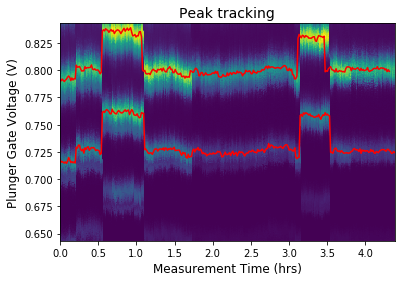

In [230]:
fig, ax1 = plt.subplots()
ax1.set_title("Peak tracking", fontsize = 14)
ax1.set_xlabel("Measurement Time (hrs)", fontsize = 12)
ax1.set_ylabel("Plunger Gate Voltage (V)", fontsize = 12)
ax1.set_axisbelow(True) # pushes grid to background
fig.set_facecolor("White")

len_x = len(tracked_peaks["time_axis"])
data_cut = np.transpose(data_raw[node_r])[:, :len_x]
ax1.pcolor(tracked_peaks["time_axis"]/3600, data_raw[gates], data_cut)
for tracked_peak in tracked_peaks["tracked_peak_positions"]:
    length = min([len(tracked_peaks["time_axis"]), len(tracked_peak)])
    ax1.plot(tracked_peaks["time_axis"][:length]/3600, tracked_peak[:length], color = "r")
#fig.savefig(os.path.join(savepath, "peak_tracking.png"), dpi = 400)

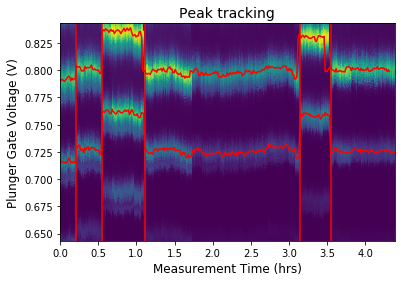

In [231]:
peak_no = 0
jump_analysis = jump_count(tracked_peaks["tracked_peak_positions"][peak_no], tracked_peaks["time_axis"])
jump_analysis.big_jump_minimum_height = 10e-3
jump_hist, big_jumps = jump_analysis.analyze()

fig, ax1 = plt.subplots()
ax1.set_title("Peak tracking", fontsize = 14)
ax1.set_xlabel("Measurement Time (hrs)", fontsize = 12)
ax1.set_ylabel("Plunger Gate Voltage (V)", fontsize = 12)
ax1.set_axisbelow(True) # pushes grid to background
fig.set_facecolor("White")
ax1.pcolor(tracked_peaks["time_axis"]/3600, data_raw[gates], data_cut)
for tracked_peak in tracked_peaks["tracked_peak_positions"]:
    length = min([len(tracked_peaks["time_axis"]), len(tracked_peak)])
    ax1.plot(tracked_peaks["time_axis"][:length]/3600, tracked_peak[:length], color = "r")
for jump_time in big_jumps["time_of_big_jumps"]/3600:
    ax1.axvline(jump_time, color = "r")

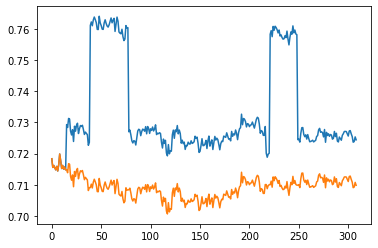

In [262]:
dejumped_trace = remove_jumps(tracked_peaks["tracked_peak_positions"][peak_no], 8.5e-3)
plt.plot(tracked_peaks["tracked_peak_positions"][peak_no])
plt.plot(dejumped_trace)

2
0


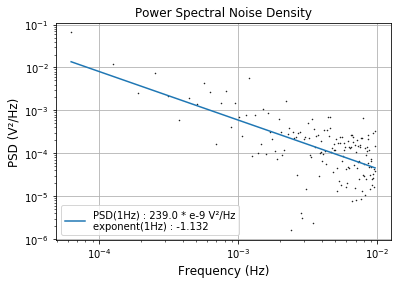

In [263]:
type_of_fit = "lin"
if type_of_fit == "lin":
    fit_func = linear
    guess = [-1, 1]
elif type_of_fit == "bilin":
    fit_func = bilinear2
    guess = [-2, 1, -1, -3]
    
sampling_f = tracked_peaks["time_axis"][1]**-1
noise_calculator = AnalyzerTimetraceSpectralNoiseDensity(dejumped_trace,\
                                                        sampling_f, fit_func = fit_func)

noise_calculator.welch_segment_length = 300
noise_calculator.guess = guess
saver.add_info(f"{node_r}_peak{peak_no}_welch_segment_length", noise_calculator.welch_segment_length)
saver.add_info(f"{node_r}_peak{peak_no}_fit_interval", noise_calculator.fit_interval)

spectral_result = noise_calculator.analyze()
saver.add_info(f"{node_r}_peak{peak_no}_spectrum", spectral_result)
saver_overview.add_info(f"{node_r}_peak{peak_no}_spectrum", spectral_result)

fit = noise_calculator.fit()
saver.add_info(f"{node_r}_peak{peak_no}_SNDfit_parameters", fit)
saver_overview.add_info(f"{node_r}_peak{peak_no}_SNDfit_parameters", fit)

f, s = spectral_result["freq"], spectral_result["spectrogram"]
saving_path = os.path.join(settings["file_info"]["savepath"], node_r)

plotter_SND = PlotterTimetraceSpectralNoiseDensity(saving_path, [f,s], fit)
plotter_SND.plot()

In [225]:
a = remove_jumps(tracked_peaks["tracked_peak_positions"][0], 10e-3)                
print(len(a))

309


In [226]:
a = remove_jumps(tracked_peaks["tracked_peak_positions"][0], 10e-3)                
print(len(a))

309


In [182]:
prev_idx = 0
jumped = 0
a = np.array([])
for idx, height in zip(big_jumps["idx_of_big_jumps"], big_jumps["height_of_big_jumps"]):
    len_x = idx - prev_idx
    prev_idx = idx    
    a = np.concatenate((a, np.ones(len_x) * jumped))
    jumped += height
    print(jumped)

a = np.concatenate((a, np.ones(len(tracked_peaks["tracked_peak_positions"][0]) - len(a)) * jumped))
print(len(a))

0.014543190631954861
0.05214138577074712
0.018665893970373215
0.05692609531296988
0.023169239159041122
309


In [193]:
b = tracked_peaks["tracked_peak_positions"][0]- a
c = tracked_peaks["tracked_peak_positions"][0]
plt.plot(b)
plt.plot(c)

ValueError: operands could not be broadcast together with shapes (309,) (249,) 

In [142]:
a = np.ones(len_x) * height

In [118]:
np.concatenate(a, [1,2])

TypeError: 'list' object cannot be interpreted as an integer